In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax.numpy as jnp

from rgm import *
from atari.common import *

In [3]:
env = make_game(EnvConfig("Breakout", ObservationType.MINI))

In [4]:
env.action_space.n

3

In [5]:
from tqdm import tqdm

observations = []
actions = []
rewards = []

num_episodes = 1
horizon = 128

for n in tqdm(range(num_episodes)):
    acs = []
    os = []
    rs = []


    obs, info = env.reset()
    for i in range(horizon):
        action = env.action_space.sample()
        next_obs, reward, done, trunc, info  = env.step(action)

        acs.append([action])
        os.append(obs)
        rs.append(reward)
        obs = next_obs

        if done:
            obs, info = env.reset()
      
    observations.append(os)
    actions.append(acs)
    rewards.append(rs)

observations = jnp.asarray(observations, dtype=jnp.float32)
actions = jnp.asarray(actions)
rewards = jnp.asarray(rewards)

100%|██████████| 1/1 [00:00<00:00, 659.59it/s]
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [6]:
observations.shape

(1, 128, 10, 10, 4)

In [7]:
import numpy as np
import seaborn as sns
from matplotlib import colors

def render(observation):
    cmap = sns.color_palette("cubehelix", observation.shape[-1])
    cmap.insert(0, (0, 0, 0))
    cmap = colors.ListedColormap(cmap)
    bounds = [i for i in range(observation.shape[-1] + 2)]
    norm = colors.BoundaryNorm(bounds, observation.shape[-1] + 1)
    numerical_state = np.amax(observation * np.reshape(np.arange(observation.shape[-1]) + 1, (1, 1, -1)), 2) + 0.5
    img = cmap(norm(numerical_state))
    return img[:, :, :3]

In [8]:
import mediapy

imgs = [ render(observations[0, i]) for i in range(horizon) ]


with mediapy.set_show_save_dir("/tmp"):
    mediapy.show_videos({"breakout": imgs}, width=320, height=320, fps=20, codec="gif")

breakout


In [9]:
print(observations.shape)
print(actions.shape)
print(rewards.shape)

(1, 128, 10, 10, 4)
(1, 128, 1)
(1, 128)


In [10]:
def to_one_hot(o):
    zero_mask = jnp.all(o == 0, axis = -1)  # shape of batch x time x 10 x 10
    arr = jnp.zeros((o.shape[0], o.shape[1], o.shape[2], o.shape[3], o.shape[4] + 1), dtype=jnp.float32)
    arr = arr.at[..., :4].set(o)
    arr = arr.at[zero_mask, 4].set(1)
    return arr

In [11]:
o = to_one_hot(observations)[0].reshape(-1, 100, 5).transpose(1, 0, 2)
a = actions[0]

In [12]:
def generate_factor_list_diagonal(dim):
    factor_list = []
    for i in range(dim):
        for j in range(dim):
            factors = []
            factors.append(i * dim + j)
            if i > 0:
                factors.append((i - 1) * dim + j)
            if i < dim - 1:
                factors.append((i + 1) * dim + j)
            if j > 0:
                factors.append(i * dim + j - 1)
            if j < dim - 1:
                factors.append(i * dim + j + 1)
            if i > 0 and j > 0:
                factors.append((i - 1) * dim + j - 1)
            if i > 0 and j < dim - 1:
                factors.append((i - 1) * dim + j + 1)
            if i < dim - 1 and j > 0:
                factors.append((i + 1) * dim + j - 1)
            if i < dim - 1 and j < dim - 1:
                factors.append((i + 1) * dim + j + 1)
            factor_list.append(factors)

    return factor_list

In [13]:
from itertools import product

def generate_policies(time_horizon, n_actions, n_modalities):
    # Generate policies that are the same action for each modality!
    return jnp.expand_dims(
        jnp.array(list(product(jnp.arange(n_actions).tolist(), repeat=time_horizon))),
        -1,
    ).repeat(n_modalities, -1)

In [14]:
import jax
import jax.numpy as jnp
from pymdp.agent import Agent

dim = 10
n_modalities = dim * dim
n_states = 5
n_batch = 1
n_actions = 3

A_dependencies = [[i] for i in range(n_modalities)]
B_dependencies = generate_factor_list_diagonal(dim)

A = [jnp.expand_dims(jnp.eye(n_states), 0).repeat(n_batch, 0)for _ in range(n_modalities)]

B_shapes = []
for i in range(n_modalities):
    n_states_dims = len(B_dependencies[i]) + 1
    B_shapes.append([n_batch] + [n_states] * n_states_dims + [n_actions])
B = [
    jnp.ones(B_shapes[i]) / B_shapes[i][1]
    for i in range(n_modalities)
]

pA = None
pB = jax.tree_util.tree_map(lambda x: jnp.ones_like(x) / x.shape[1], B)

D = [jnp.ones((n_batch, n_states)) / n_states for _ in range(n_modalities)]

policies = generate_policies(1, n_actions, n_modalities)

agent = Agent(
    A=A,
    B=B,
    C=D,
    D=D,
    E=None,
    pA=pA,
    pB=pB,
    A_dependencies=A_dependencies,
    B_dependencies=B_dependencies,
    onehot_obs=True,
    action_selection="deterministic",
    sampling_mode="full",
    inference_algo="mmp",
    learn_A=False,
    num_iter=16,
    policies=policies,
    policy_len=1,
    apply_batch=False,
)

In [15]:
from pymdp.maths import multidimensional_outer

@jax.vmap
def count(*args):
    """
    Double vmapped counting method, i.e. args and a have to be of shape
    (n_batch, n_time, state_dim)

    can be arbitrary many: [state_i, state_dep..., action]
     but for this case it would be [s1, s0, a]

    """
    return jax.vmap(multidimensional_outer)(args)


def update_B(qB, cats, actions, B_dependencies, lr_pB=1.0):
    a = jax.nn.one_hot(actions, num_classes=env.action_space.n)
    # split in previous (t=0) states (s0) and current (t=1) states (s1)
    # with a being the action at t=0 to go from s0 -> s1

    s0 = jtu.tree_map(lambda x: x[:, :-1], cats)
    s1 = jtu.tree_map(lambda x: x[:, 1:], cats)

    for f in range(len(qB)):
        deps = [s0[fi] for fi in B_dependencies[f]]
        dfdb = count(s1[f], *deps, a).sum(axis=[0, 1])
        qB[f] = qB[f] + lr_pB * jnp.expand_dims(dfdb, 0)

    E_qB = [b / b.sum(axis=1, keepdims=True) for b in qB]
    return qB, E_qB

In [16]:
outcomes = [jnp.expand_dims(obs, 0) for obs in o]

In [17]:
outcomes[0].shape

(1, 128, 5)

In [18]:
# convert to one-hot actions and remove final action 
acts = jnp.expand_dims(a.squeeze(-1)[:actions.shape[1]-1], 0)

In [19]:
acts.shape

(1, 127)

In [20]:
print(acts)

[[2 1 1 2 1 1 1 0 0 2 0 0 1 2 1 2 0 0 2 0 0 1 1 1 2 2 2 1 0 1 0 1 1 0 1 2
  2 0 1 2 0 0 1 0 1 2 2 2 1 0 1 1 0 0 2 0 1 1 0 2 2 2 0 2 2 1 2 1 0 1 0 1
  0 2 0 0 0 0 0 2 2 0 1 1 0 2 0 0 0 2 2 0 1 0 2 1 0 1 0 0 0 2 1 2 2 1 1 0
  2 2 2 0 1 1 0 1 2 1 2 2 1 2 0 0 2 2 0]]


In [21]:
qB, E_qB = update_B(agent.pB, outcomes, acts, B_dependencies)

In [22]:
import equinox as eqx

agent = eqx.tree_at(lambda x: x.pB, agent, qB)
agent = eqx.tree_at(lambda x: x.B, agent, E_qB)

In [23]:
o_t = jtu.tree_map(lambda x: jnp.expand_dims(x[:, 1, :], 1), outcomes)

In [24]:
qs = agent.infer_states(o_t, agent.D)

In [25]:
qs[0].shape

(1, 1, 5)

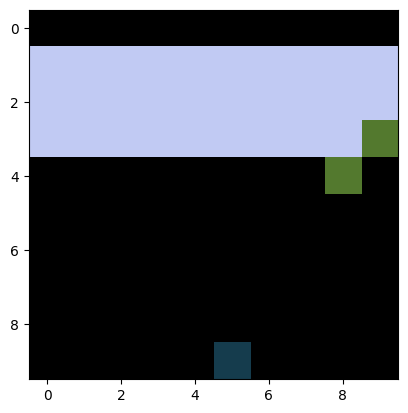

In [26]:
import matplotlib.pyplot as plt
init = jnp.asarray(qs)[:, 0, 0, :].reshape(10, 10, 5)[:, :, :4]
plt.imshow(render(init))

In [27]:
from jax import vmap
import jax.tree_util as jtu
from functools import partial
import pymdp.control as control


def predict(agent, qs, action, n_steps=1):
    qs_pred = []
    qs_last = jtu.tree_map(lambda x: x[:, -1], qs)

    for _ in range(n_steps):
        propagate_beliefs = partial(
            control.compute_expected_state,
            B_dependencies=agent.B_dependencies,
        )
        qs_next = vmap(propagate_beliefs)(qs_last, agent.B, action)
        qs_pred.append(qs_next)
        qs_last = qs_next

    return jnp.asarray(qs_pred)

In [28]:
act = policies[0]

In [29]:
qs_next = predict(agent, qs, policies[0], 2)

noop

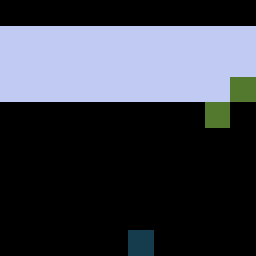

In [30]:
imgs = [render(init)]
for i in range(qs_next.shape[0]):
    nxt = jnp.asarray(qs_next)[i, :, 0, :].reshape(10, 10, 5)[:, :, :4]
    imgs.append(render(nxt))

from PIL import Image
resize = lambda x: jnp.array(Image.fromarray((x * 255).astype(jnp.uint8)).resize((256, 256), Image.NEAREST))
big = [resize(img) for img in imgs]

with mediapy.set_show_save_dir("/tmp"):
    mediapy.show_videos({"noop": big}, width=320, height=320, fps=2, codec="gif")

left

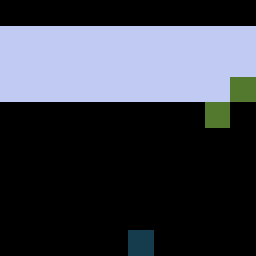

In [31]:
qs_next = predict(agent, qs, policies[1], 2)
imgs = [render(init)]
for i in range(qs_next.shape[0]):
    nxt = jnp.asarray(qs_next)[i, :, 0, :].reshape(10, 10, 5)[:, :, :4]
    imgs.append(render(nxt))

from PIL import Image

resize = lambda x: jnp.array(Image.fromarray((x * 255).astype(jnp.uint8)).resize((256, 256), Image.NEAREST))
big = [resize(img) for img in imgs]

with mediapy.set_show_save_dir("/tmp"):
    mediapy.show_videos({"left": big}, width=320, height=320, fps=2, codec="gif")

right

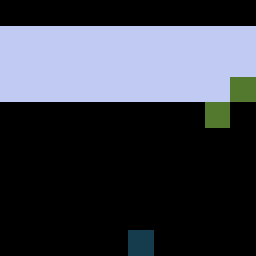

In [32]:
qs_next = predict(agent, qs, policies[2], 2)
imgs = [render(init)]
for i in range(qs_next.shape[0]):
    nxt = jnp.asarray(qs_next)[i, :, 0, :].reshape(10, 10, 5)[:, :, :4]
    imgs.append(render(nxt))

from PIL import Image

resize = lambda x: jnp.array(Image.fromarray((x * 255).astype(jnp.uint8)).resize((256, 256), Image.NEAREST))
big = [resize(img) for img in imgs]

with mediapy.set_show_save_dir("/tmp"):
    mediapy.show_videos({"right": big}, width=320, height=320, fps=2, codec="gif")